In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.LNK_data import *
from torchdeepretina.utils import *
import torchdeepretina.stimuli as tdrstim
from torchdeepretina.visualizations import plot_filters
from torchdeepretina.retinal_phenomena import *
from kinetic.notebook.functions import *

In [4]:
device = torch.device('cuda:3')
dt = 0.01
cfg = get_custom_cfg('channel_filter_LNK')
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_NoScale/epoch_005_loss_-30.31_pearson_0.4725.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model = OnePixelModel(cfg, checkpoint['model_state_dict'], dt, device)

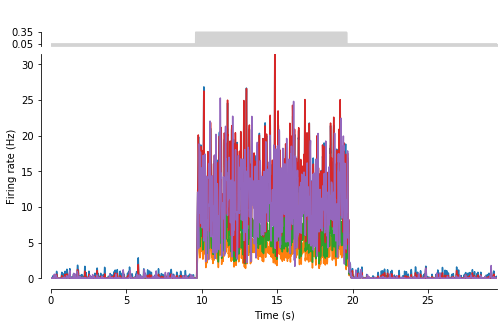

In [6]:
Rs, As, I1s, I2s, us, after_filters, after_amacrines = contrast_adaptation_onepixel_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, n_repeats=10)

In [7]:
ka = checkpoint['model_state_dict']['kinetics.ka'].cpu().numpy().squeeze(-1)
kfi = checkpoint['model_state_dict']['kinetics.kfi'].cpu().numpy().squeeze(-1)
kfr = checkpoint['model_state_dict']['kinetics.kfr'].cpu().numpy().squeeze(-1)
u_l = (us[:960, :].mean(axis=0) + us[2000:, :].mean(axis=0))/2
u_h = us[1000:1960, :].mean(axis=0)
A_l = (As[:960, :].mean(axis=0) + As[2000:, :].mean(axis=0))/2
A_h = As[1000:1960, :].mean(axis=0)
A_h -= A_h * 0.1
decay_rate = 0.5
ksi, ksr, I20 = slow_parameters_solver(A_l, A_h, decay_rate, kfi, kfr, ka, u_l, u_h)

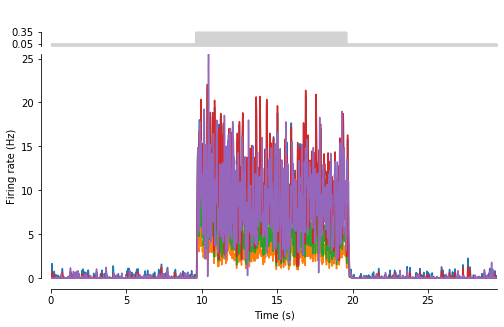

In [7]:
device = torch.device('cuda:3')
dt = 0.01
cfg = get_custom_cfg('channel_filter_LNK')
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_NoScale/epoch_005_loss_-30.31_pearson_0.4725.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model = OnePixelModel(cfg, checkpoint['model_state_dict'], dt, device)
model.kinetics.ksi.data = torch.tensor(ksi)[:, None].to(device)
model.kinetics.ksr.data = torch.tensor(ksr)[:, None].to(device)
Rs, As, I1s, I2s, us, after_filters, after_amacrines = contrast_adaptation_onepixel_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, I20=torch.from_numpy(I20)[:,None].to(device), n_repeats=10)

In [8]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('channel_filter_LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/channel_filter_LNK_NoNorm_NoScale/epoch_005_loss_-30.31_pearson_0.4725.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.kinetics.ksi.data = torch.tensor(ksi)[:, None].to(device)
model.kinetics.ksr.data = torch.tensor(ksr)[:, None].to(device)

In [9]:
def get_hook(layer_dict, key, to_numpy=True, to_cpu=False):
    if to_numpy:
        def hook(module, inp, out):
            layer_dict[key] = out.detach().cpu().numpy()
    elif to_cpu:
        def hook(module, inp, out):
            layer_dict[key] = out.cpu()
    else:
        def hook(module, inp, out):
            layer_dict[key] = out
    return hook

In [10]:
def inspect_rnn(model, X, hs, insp_keys=[]):

    layer_outs = dict()
    handles = []
    for key, mod in model.named_modules():
        if key in insp_keys:
            hook = get_hook(layer_outs, key, to_numpy=True)
            handle = mod.register_forward_hook(hook)
            handles.append(handle)

    resps = []
    layer_outs_list = {key:[] for key in insp_keys}
    with torch.no_grad():
        for i in range(X.shape[0]):
            resp, hs = model(X[i:i+1], hs)
            resps.append(resp)
            for k in layer_outs.keys():
                layer_outs_list[k].append(layer_outs[k])
    
    layer_outs = {k:np.concatenate(v,axis=0) for k,v in layer_outs_list.items()}
    resp = torch.cat(resps, dim=0)
    layer_outs['outputs'] = resp.detach().cpu().numpy()
    
    for i in range(len(handles)):
        handles[i].remove()
    del handles
    
    return layer_outs

In [11]:
def revcor_sta_rnn(model, layers, device, I20=None):
    
    chans = model.chans
    noise = np.random.randn(10000,50,50)
    try:
        filter_size = model.img_shape[0]
    except:
        filter_size = model.image_shape[0]
    X = tdrstim.concat(noise, nh=filter_size)
    X = torch.FloatTensor(X).to(device)
    noise = noise[filter_size:]
    hs = get_hs(model, 1, device, I20)
    
    response = inspect_rnn(model, X, hs, insp_keys=list(layers))
    stas = {layer:[] for layer in layers}
    for layer,chan in zip(layers,chans):
        resp = response[layer]
        if len(resp.shape) == 2:
            if layer == "sequential.2":
                resp = resp.reshape(len(resp), len(chan), *model.shapes[0])
            else:
                resp = resp.reshape(len(resp), len(chan), *model.shapes[1])
        centers = np.array(resp.shape[2:])//2
        for c in range(chan):
            if len(centers) == 2:
                sta,_ = ft.revcorr(noise, scipy.stats.zscore(resp[:, c, centers[0], centers[1]]),
                                                             0, filter_size)
            if len(centers) == 3:
                sta,_ = ft.revcorr(noise, scipy.stats.zscore(resp[:, c, centers[0], centers[1], centers[2]]),
                                                             0, filter_size)
            stas[layer].append(sta)
    return stas

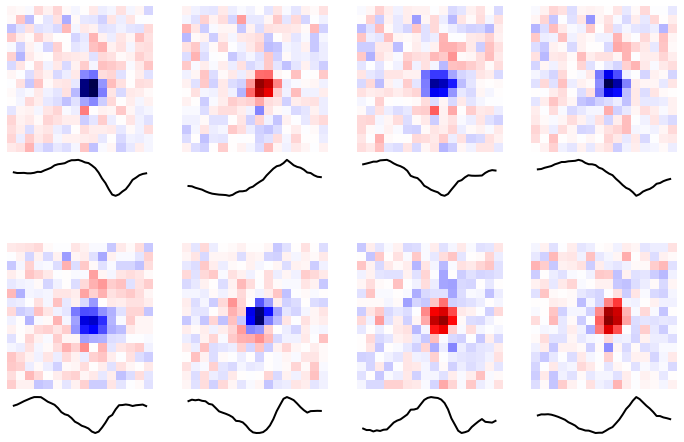

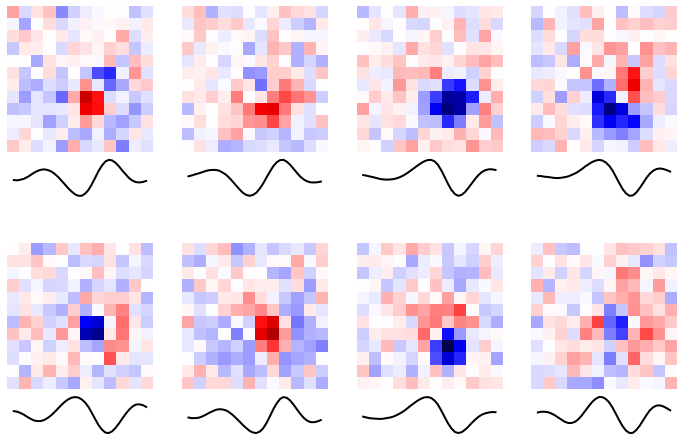

In [12]:
layers = ['bipolar.0', 'amacrine.2']
stas = revcor_sta_rnn(model, layers, device, I20)
fig = plot_filters(np.stack(stas['bipolar.0']), 15)
fig = plot_filters(np.stack(stas['amacrine.2']), 11)

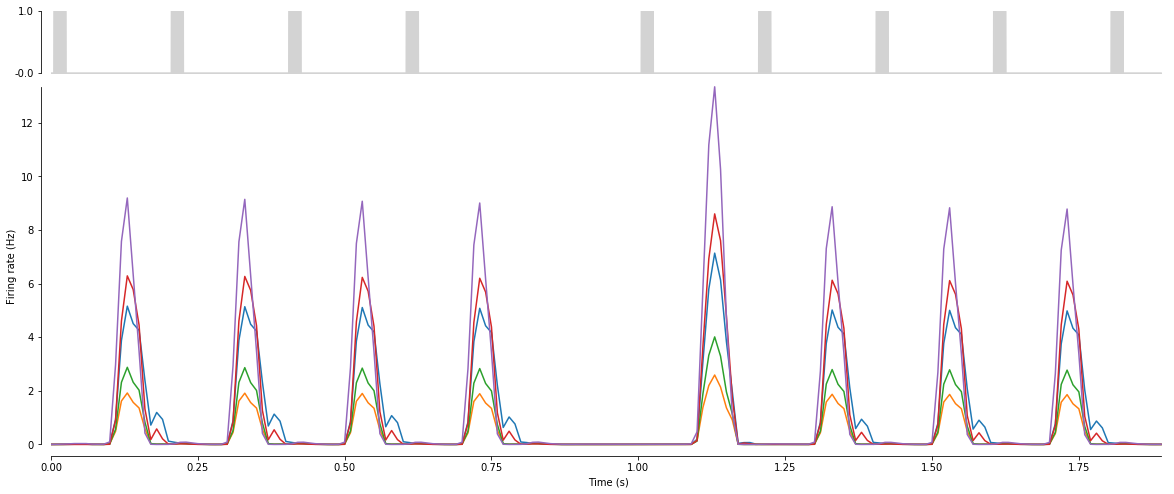

In [12]:
fig, _, _, _ = osr(device, I20, model)

51it [00:03, 15.74it/s]


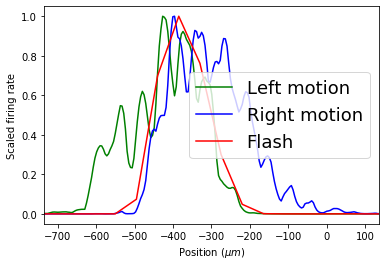

In [17]:
fig, _, _, _, _ = motion_anticipation(device, I20, model)

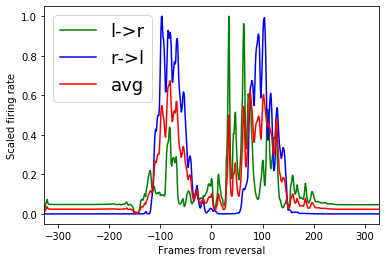

In [19]:
fig, _, _, _, _ = motion_reversal(device, I20, model)

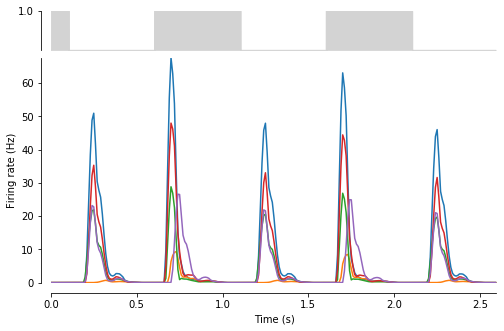

In [21]:
fig, _, _ = reversing_grating(device, I20, model)

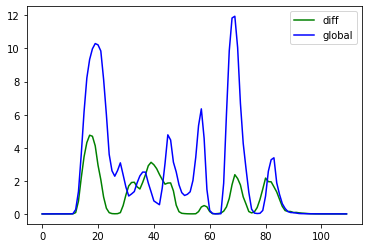

In [23]:
fig, _, _, _, _ = oms_random_differential(device, I20, model)

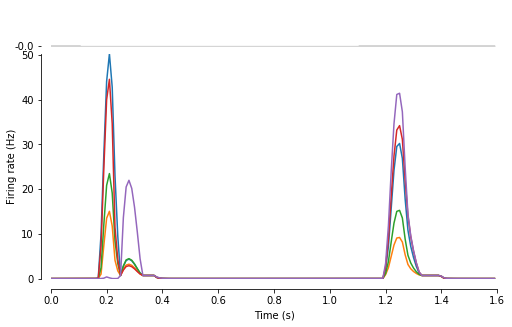

In [24]:
fig, _, _ = step_response(device, I20, model)

[-3.14782163e-09 -2.97867397e-09 -2.80952630e-09 -2.64037864e-09
 -2.47123098e-09 -2.30208332e-09 -2.13293566e-09 -1.96378799e-09
 -1.79464033e-09 -1.62549267e-09 -1.45634501e-09 -1.28719735e-09
 -1.11804968e-09 -9.48902023e-10 -7.79754361e-10 -6.10606699e-10
 -4.41459037e-10 -2.72311375e-10 -1.03163713e-10  6.59839492e-11
  2.35131611e-10  4.04279273e-10  5.73426935e-10  7.42574597e-10
  9.11722259e-10  1.08086992e-09  1.25001758e-09  1.41916525e-09
  1.58831291e-09  1.75746057e-09  1.92660823e-09  2.09575589e-09
  2.26490356e-09  2.43405122e-09  2.60319888e-09  2.77234654e-09
  2.94149420e-09  3.11064186e-09  3.27978953e-09  3.44893719e-09] [0.00042305 0.00042192 0.00042079 0.00041965 0.00041852 0.00041739
 0.00041625 0.00041449 0.00041233 0.0004153  0.00041323 0.00041257
 0.00041533 0.00041503 0.00041488 0.00041411 0.00041511 0.00041674
 0.00041444 0.00041616 0.00041697 0.00041742 0.00041772 0.00041735
 0.00041774 0.00041729 0.00041849 0.00041828 0.0004196  0.00042074
 0.00042129 0.

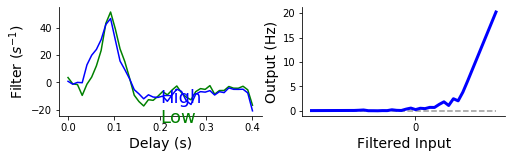

In [38]:
contrasts = [0.05, 0.35]
fig = contrast_fig(model, device, I20, contrasts, unit_index=3, layer_name='ganglion')